In [ ]:
#https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
#https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808

Marina Dunn

PHYS 243 HW3

Fall 2021

Prof. Mobasher

* Review kaggle notebook (https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) from class which was created to predict the likelihood of surviving the Titanic sinking.

Goal: Perform a PCA analysis on this dataset and compare the PCA feature weights with the techniques used in the notebook above.

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv', header = 0, dtype={'Age': np.float64})
test = pd.read_csv('../input/test.csv', header = 0, dtype={'Age': np.float64})
outcome = pd.read_csv('../input/gender_submission.csv', header = 0, dtype={'Age': np.float64}) 

# Store our passenger ID for easy access
PassengerId = train['PassengerId']
PassengerId = test['PassengerId']

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train.isnull().sum() 
# we are missing values for embarked, age, and cabin, so we will have to account for these

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


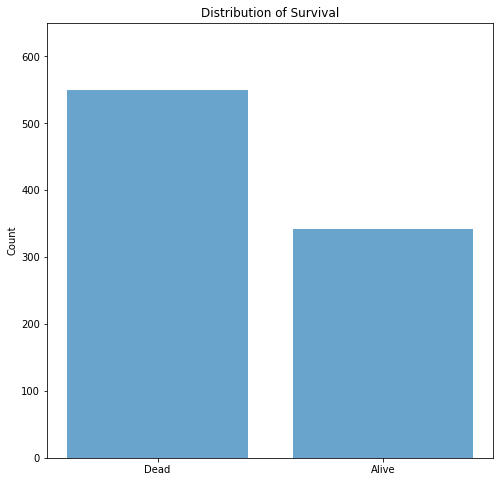

In [6]:
# initial looks
# survival distribution
plt.figure(figsize=(8,8))
test_plt = test.merge(outcome, on="PassengerId")
full_data = pd.concat([train, test])
barr = plt.bar( full_data.Survived.value_counts().index,  full_data.Survived.value_counts(), alpha = 0.67, )
plt.title('Distribution of Survival')
plt.ylabel('Count')
plt.xticks([0,1], ['Dead','Alive'])

plt.ylim((0,650))
barr = plt.gcf()
plt.rcParams["figure.figsize"] = (12,6)

plt.show()

In [7]:
X_train = train.copy()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
X_test = test.copy()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**Understanding the data**

The training set contains 891 passengers, and the test set contains 418 passengers.
The training set includes whether the passengers survived or not. By merging the test and gender_submission files, we can see the survival values for the remaining 418 passengers. There are missing values that need to be accounted for, and many factors, such as the person's name, will not be factored into whether they survived or not. We will also have to use numerical values to compare features, so string features will have to be changed to numerical values. 

When the Titanic sank, the common saying was that the "women and children" go onto the lifeboats first, so we will likely expect to see a higher survival rate in women and younger children, especially those in the wealthier classes. Because people of lower class were located further down in the ship, we suspect that there will be a lower survival rate with this class, especially men.

Parameters:

*Pclass: Passenger’s class, 1 being highest class, 3 being lowest class

*Survived: If the individual survived (1) or died (0)

*Age: Age of individual at time of Titanic event

*Sex: Gender of individual

*Name: Name of individual (if individual was female, lists husband's name in addition to maiden name in parentheses). Also includes title, which other's have used as a factor into survival rate

*SibSp:the number of siblings/spouses 

*Parch: the number of children/parents

*Ticket: Ticket number

*Fare: Fare paid

*Cabin: Cabin number onboard, first character is the deck

*Embarked: Port of embarkation

*PassengerId: identification number of passenger, used as our index

In [9]:
# fill in Embarked status, cabin, fare and age for NULL values
# for embarked, fill with the most occurred value ( 'S' )

values = {"Embarked": 'S', "Cabin": 0}
X_train = X_train.fillna(value=values)
X_test = X_test.fillna(value=values)

In [11]:
pd.options.mode.use_inf_as_na = True # make non-filled values show as NaN to correct

# fill null fare with average fare
values = X_train.Fare.mean()
X_train['Fare'] = X_train.Fare.fillna(values)
X_train = X_train.astype({'Fare': 'int64'})
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null int64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 83.6+ KB


In [12]:
values = X_test.Fare.mean()
X_test['Fare'] = X_test.Fare.fillna(values)
X_test = X_test.astype({'Fare': 'int64'})
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null int64
Cabin          418 non-null object
Embarked       418 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 36.0+ KB


In [13]:
# for age, generate random numbers between (mean - std) and (mean + std)
# then we categorize age into 5 range.
age_avg = X_train['Age'].mean()
age_std = X_train['Age'].std()
age_null_count = X_train['Age'].isnull().sum()
    
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
X_train['Age'][np.isnan(X_train['Age'])] = age_null_random_list
X_train['Age'] = X_train['Age'].astype(int)

In [14]:
age_avg = X_test['Age'].mean()
age_std = X_test['Age'].std()
age_null_count = X_test['Age'].isnull().sum()
    
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
X_test['Age'][np.isnan(X_test['Age'])] = age_null_random_list
X_test['Age'] = X_test['Age'].astype(int)

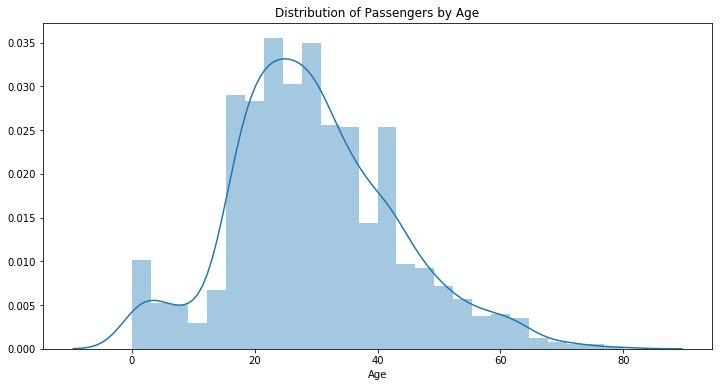

In [15]:
# initial look of survival by age
plt.figure(figsize=(12,6))
full_data = pd.concat([X_train, X_test])
sns.distplot(full_data.Age, )
plt.title('Distribution of Passengers by Age')
plt.show()

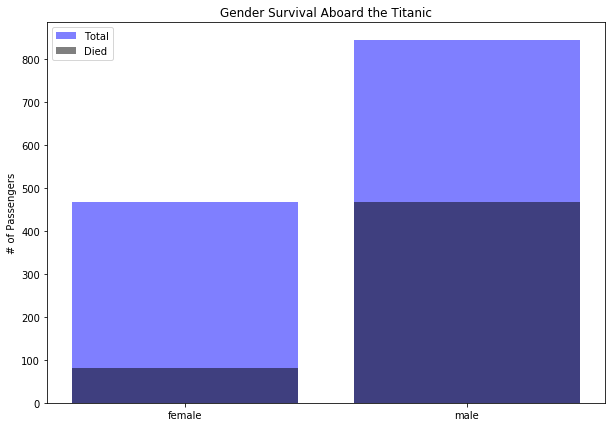

In [16]:
# initial look of survival by sex
dead = full_data[full_data.Survived == 0]

plt.figure(figsize = (10,7))
plt.bar( full_data['Sex'].value_counts().index,  full_data['Sex'].value_counts(), label = 'alive', color = 'blue', alpha = 0.5 )
plt.bar( dead['Sex'].value_counts().index,  dead['Sex'].value_counts(), label = 'dead', color = 'black', alpha = 0.5 )
plt.legend(['Total','Died'])
plt.title('Gender Survival Aboard the Titanic')
plt.ylabel('# of Passengers')

plt.show()

In [17]:
# for later
X = full_data.copy()

In [18]:
X_train['CategoricalAge'] = pd.cut(X_train['Age'], 5)
X_test['CategoricalAge'] = pd.cut(X_test['Age'], 5)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null object
Age               891 non-null int64
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null int64
Cabin             891 non-null object
Embarked          891 non-null object
CategoricalAge    891 non-null category
dtypes: category(1), int64(7), object(5)
memory usage: 84.6+ KB


In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId       418 non-null int64
Pclass            418 non-null int64
Name              418 non-null object
Sex               418 non-null object
Age               418 non-null int64
SibSp             418 non-null int64
Parch             418 non-null int64
Ticket            418 non-null object
Fare              418 non-null int64
Cabin             418 non-null object
Embarked          418 non-null object
CategoricalAge    418 non-null category
dtypes: category(1), int64(6), object(5)
memory usage: 36.5+ KB


In [21]:
# Because numerical values are required in order to do PCA, we will have to change some
# columns into numerical types before performing it

In [22]:
# Mapping Sex
X_train['Sex'] = X_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
X_test['Sex'] = X_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping Embarked
X_train['Embarked'] = X_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
X_test['Embarked'] = X_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [23]:
# Mapping Fare
X_train.loc[ X_train['Fare'] <= 7.91, 'Fare'] = 0
X_train.loc[(X_train['Fare'] > 7.91) & (X_train['Fare'] <= 14.454), 'Fare'] = 1
X_train.loc[(X_train['Fare'] > 14.454) & (X_train['Fare'] <= 31), 'Fare'] = 2
X_train.loc[ X_train['Fare'] > 31, 'Fare'] = 3

X_test.loc[ X_test['Fare'] <= 7.91, 'Fare'] = 0
X_test.loc[(X_test['Fare'] > 7.91) & (X_test['Fare'] <= 14.454), 'Fare'] = 1
X_test.loc[(X_test['Fare'] > 14.454) & (X_test['Fare'] <= 31), 'Fare'] = 2
X_test.loc[ X_test['Fare'] > 31, 'Fare'] = 3
    
# Mapping Age, generate random numbers between (mean - std) and (mean + std). 
# then categorize age into 5 range.
X_train.loc[ X_train['Age'] <= 16, 'Age'] = 0
X_train.loc[(X_train['Age'] > 16) & (X_train['Age'] <= 32), 'Age'] = 1
X_train.loc[(X_train['Age'] > 32) & (X_train['Age'] <= 48), 'Age'] = 2
X_train.loc[(X_train['Age'] > 48) & (X_train['Age'] <= 64), 'Age'] = 3
X_train.loc[ X_train['Age'] > 64, 'Age'] = 4
X_train.info()

X_test.loc[X_test['Age'] <= 16, 'Age'] = 0
X_test.loc[(X_test['Age'] > 16) & (X_test['Age'] <= 32), 'Age'] = 1
X_test.loc[(X_test['Age'] > 32) & (X_test['Age'] <= 48), 'Age'] = 2
X_test.loc[(X_test['Age'] > 48) & (X_test['Age'] <= 64), 'Age'] = 3
X_test.loc[ X_test['Age'] > 64, 'Age'] = 4
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null int64
Age               891 non-null int64
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null int64
Cabin             891 non-null object
Embarked          891 non-null int64
CategoricalAge    891 non-null category
dtypes: category(1), int64(9), object(3)
memory usage: 84.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId       418 non-null int64
Pclass            418 non-null int64
Name              418 non-null object
Sex               418 non-null int64
Age               418 non-null int64
SibSp             418 non-null int64
Parch           

In [24]:
y_train = X_train['Survived']
frame = {"Survived": y_train}
y_train = pd.DataFrame(frame)

In [25]:
# Feature selection
# Survived is our target
features = ["Age", "Fare", "Sex", "Pclass", "Embarked", "Parch", 'SibSp']
drop_elements = ['Name', 'Ticket', 'Cabin','CategoricalAge']
X_train = X_train.drop(drop_elements, axis = 1)
X_train = X_train.drop("Survived", axis = 1)
X_train = X_train.drop("PassengerId", axis = 1)
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,1,1,0,0,0
1,1,0,2,1,0,3,1
2,3,0,1,0,0,0,0
3,1,0,2,1,0,3,0
4,3,1,2,0,0,1,0
5,3,1,1,0,0,1,2
6,1,1,3,0,0,3,0
7,3,1,0,3,1,2,0
8,3,0,1,0,2,1,0
9,2,0,0,1,0,2,1


In [26]:
X_test = X_test.drop(drop_elements, axis = 1)
X_test = X_test.drop("PassengerId", axis = 1)
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,2,0,0,0,2
1,3,0,2,1,0,0,0
2,2,1,3,0,0,1,2
3,3,1,1,0,0,1,0
4,3,0,1,1,1,1,0
5,3,1,0,0,0,1,0
6,3,0,1,0,0,0,2
7,2,1,1,1,1,2,0
8,3,0,1,0,0,0,1
9,3,1,1,2,0,2,0


In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows
# set display options in order to see all components from pca

In [29]:
pca, X_pca, loadings = apply_pca(X_train)
print(loadings)

               PC1       PC2       PC3       PC4       PC5       PC6       PC7
Pclass   -0.398875  0.560815 -0.025451  0.020619  0.348479 -0.120992  0.623888
Sex      -0.323379 -0.103456 -0.555873  0.659583 -0.183467  0.327046  0.007675
Age       0.019615 -0.570623 -0.056455  0.199024  0.757535 -0.234619  0.047966
SibSp     0.391946  0.424319 -0.167048  0.428970  0.011653 -0.614242 -0.277457
Parch     0.439190  0.360402 -0.060392  0.027373  0.462192  0.653878 -0.177898
Fare      0.618387 -0.197842 -0.046967  0.137414 -0.236133  0.042850  0.706946
Embarked -0.083828  0.009780  0.808339  0.566805 -0.039067  0.129110 -0.001282


PC1: Fare & Parch have the most weight

PC2: Pclass & Age have the most weight

PC3: Sex & Embarked have the most weight

PC4: Sex & Embarked have the most weight, all values positively correlated

PC5: Age & Parch have the most weight

PC6: SibSp & Parch have the most weight

PC7: Pclass & Fare have the most weight



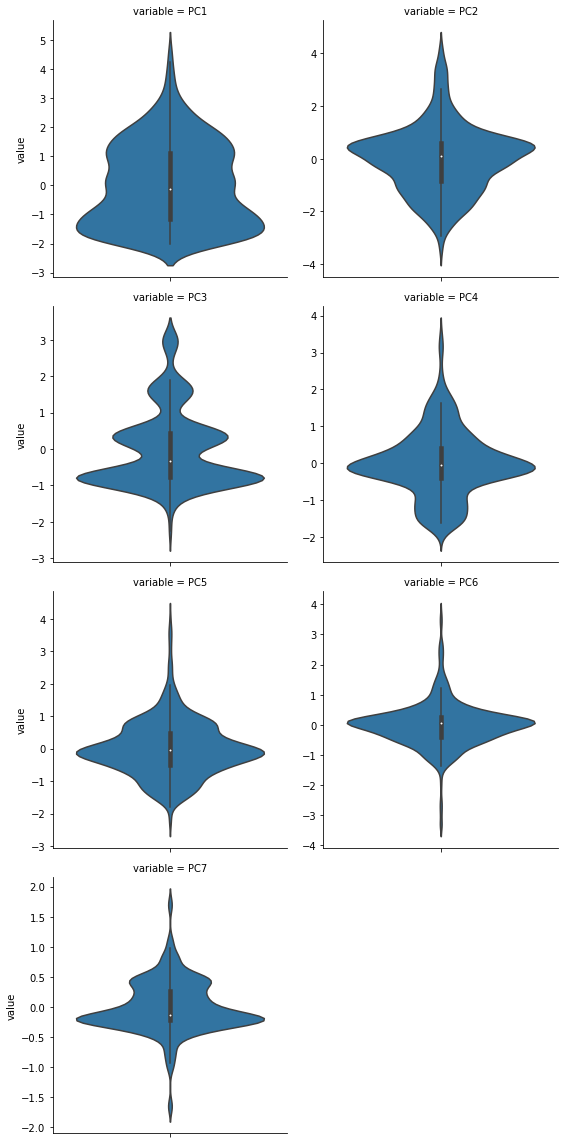

In [30]:
# Making distribution plots to see outliers
sns.factorplot(y="value", col="variable", data=X_pca.melt(), kind='violin', sharey=False, col_wrap=2)

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred_1 = logreg.predict(X_test)
acc_log = logreg.score(X_train, y_train) * 100
acc_log

79.573512906846247

In [32]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred_2 = svc.predict(X_test)
acc_svc = svc.score(X_train, y_train) * 100
acc_svc

83.16498316498317

In [33]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
Y_pred_3 = knn.predict(X_test)
acc_knn = knn.score(X_train, y_train) * 100
acc_knn

83.389450056116715

In [34]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred_4 = decision_tree.predict(X_test)
acc_decision_tree = decision_tree.score(X_train, y_train) * 100
acc_decision_tree

89.001122334455658

In [35]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, y_train)
Y_pred_5= random_forest.predict(X_test)
acc_rf = random_forest.score(X_train, y_train) * 100
acc_rf

89.001122334455658

In [36]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train)
Y_pred_6 = ada_boost.predict(X_test)
acc_rf = ada_boost.score(X_train, y_train) * 100
acc_rf

80.583613916947243

In [37]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)
Y_pred_7 = grad_boost.predict(X_test)
acc_rf = grad_boost.score(X_train, y_train) * 100
acc_rf

84.960718294051631

In [38]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train, y_train)
Y_pred_8 = extra_trees.predict(X_test)
acc_et = extra_trees.score(X_train, y_train) * 100
acc_et

89.001122334455658

Best score: DecisionTreeClassifier/RandomForest/ExtraTreesClassifier

**Final Model: ExtraTreesClassifier**

Overall best performer was a tie between DecisionTreeClassifier/RandomForest/ExtraTreesClassifier, has 85% accuracy. Will choose ExtraTreesClassifier for remaining analysis.

In [39]:
# Minimum percentage of variance we want to be described by the resulting transformed components
variance_pct = .99

# Create PCA object
pca = PCA(n_components=variance_pct)

# Transform the initial features
X_transformed = pca.fit_transform(X_train, y_train)

# Create a data frame from the PCA'd data
pcaDataFrame = pd.DataFrame(X_transformed)

print(pcaDataFrame.shape[1], " components describe ", str(variance_pct)[1:], "% of the variance")

7  components describe  .99 % of the variance


In [40]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
model = ExtraTreesClassifier()
parameters = {'max_features': ('auto', 'sqrt', 'log2'), 'max_depth':[1,100], 'min_samples_split':[2,100], 'min_samples_leaf': [1,100], 'min_weight_fraction_leaf': [0,0.5]}
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_features': ('auto', 'sqrt', 'log2'), 'max_depth': [1, 100], 'min_samples_split': [2, 100], 'min_samples_leaf': [1, 100], 'min_weight_fraction_leaf': [0, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
clf.score(X_train, y_train)* 100

89.001122334455658

In [45]:
clf.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0}

In [46]:
model = ExtraTreesClassifier(max_depth=100,max_features='sqrt',min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0)
model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=100, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
# make prediction
y_predict = model.predict(X_test)
model.score(X_train, y_train) * 100

89.001122334455658

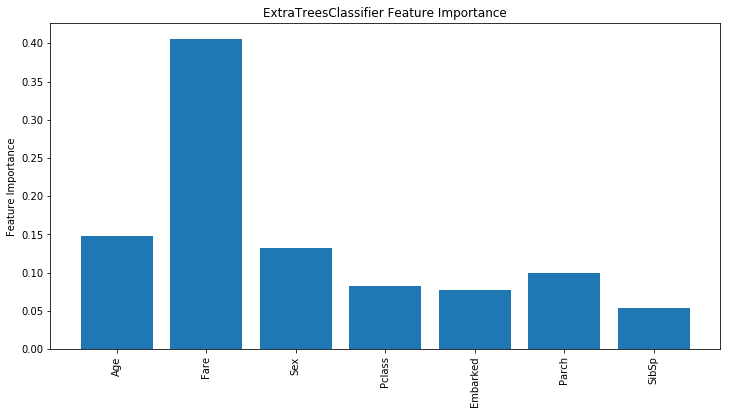

In [48]:
# Feature Importance

plt.figure(figsize=(12,6))
plt.bar(range(len(features)), model.feature_importances_)
plt.xticks(range(len(features)), features, rotation =90)
plt.ylabel('Feature Importance')
plt.title('ExtraTreesClassifier Feature Importance')
plt.show()

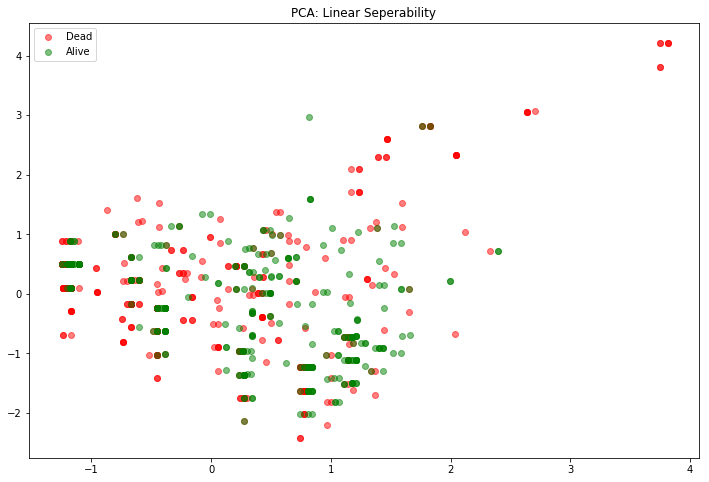

In [49]:
from sklearn.preprocessing import StandardScaler

X_transformed = StandardScaler().fit_transform(X_transformed)

died1 = X_transformed[y_train["Survived"] == 0]
live1 = X_transformed[y_train["Survived"] == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
plt.scatter(died1[:,0].reshape(1,-1), died1[:,1].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
plt.scatter(live1[:,0].reshape(1,-1), live1[:,1].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])

plt.show()

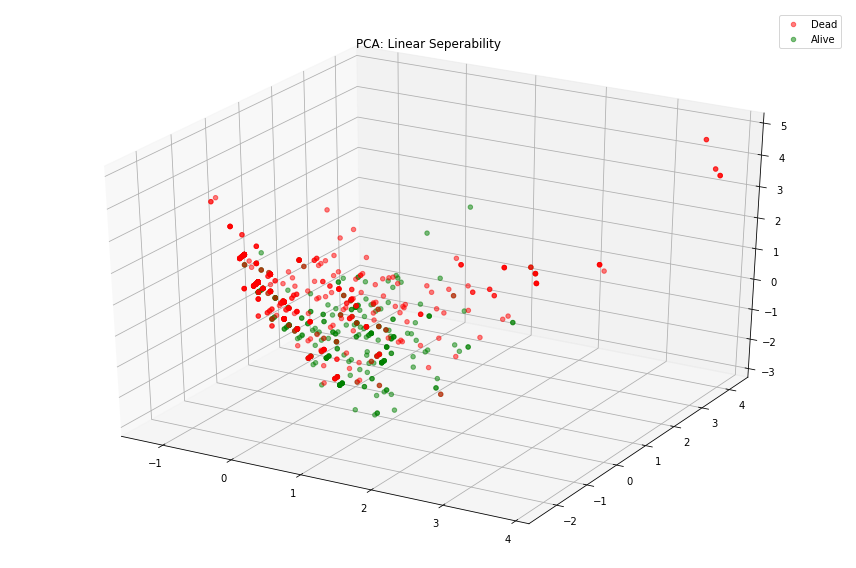

In [50]:
from mpl_toolkits.mplot3d import Axes3D


died = X_transformed[y_train["Survived"] == 0]
live = X_transformed[y_train["Survived"] == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d', )
ax.scatter(died[:,0].reshape(1,-1), died[:,1].reshape(1,-1),died[:,2].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
ax.scatter(live[:,0].reshape(1,-1), live[:,1].reshape(1,-1),live[:,2].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])
plt.tight_layout()

plt.show()

**Conclusions & Comparison**

Comparing to analysis in https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

Similar to this notebook, I added missing values for the features with null values in the same ways. However, I did not breakup the name into different components to do an analysis by title, nor did I do an analysis of cabins, tickets, or different family size pairings.

So when comparing my heatmap to the notebook's Pearson Correlation heatmap, mine has fewer features. For example, the most correlated features in mine are SibSp & Parch, whereas in the example notebook, it is Parch & Family_Size, while my least correlated are Pclass & Fare, and the example notebook's is Pclass & Has_Cabin.



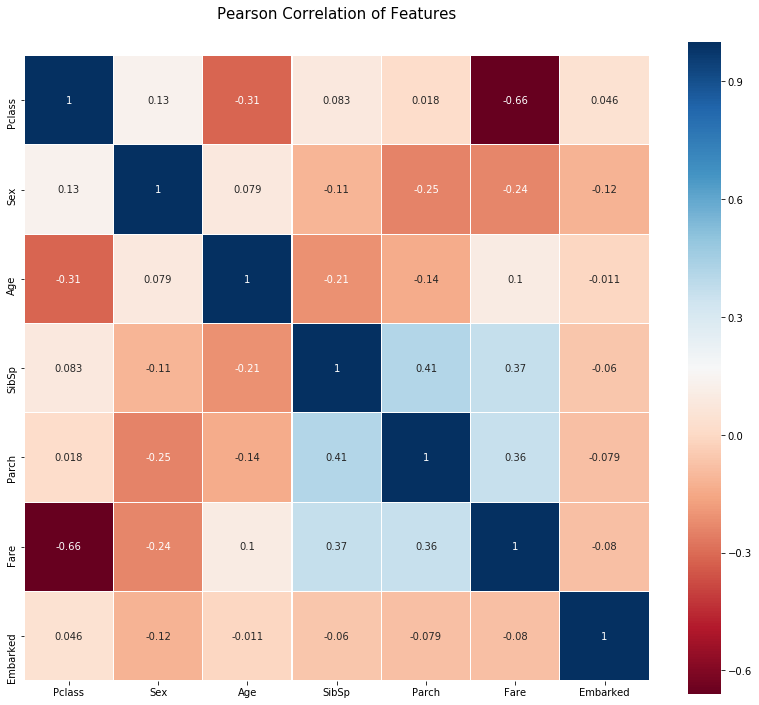

In [51]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

The example notebook used the RandomForest, ExtraTrees, AdaBoost, and GradientBoost classifiers, while I used these plus KNeighborsClassifier, DecisionTree, LogisticRegression, and SVC to test.

Compared to the example notebook, their top 3 most import features when using the ExtraTreesClassifier were 'Sex', 'FamilySize', and 'Pclass' respectively, while mine were Fare, Age, and Parch, which is interesting, but again I used less features.

The approaches to these two analyses are very different and yield different feature importances. My notebook would benefit from additional analyses, creating additional features such as 'Family Size' and 'Is Alone' and re-comparing. Family Size would require breaking down Age into 'child' values and combining the SibSp and Parch values.